# Cell type labeling, plotting, and differential gene expression analysis

# Notebook setup

In [1]:
import os
os.chdir('/local/workdir/dwm269/scCardiacOrganoid/')

In [ ]:
from itertools import chain
from itertools import product
import numpy as np
import anndata as ad
import pandas as pd

import scanpy as sc
import scanpy.external as sce

# import scvelo as scv
# import cellrank as cr
import seaborn as sns
from scipy import io
from scipy import sparse

: 

In [ ]:
from scripts.py.scantils import *
# from scripts.py.scanplots import *

: 

In [ ]:
import gc
gc.enable()

: 

In [ ]:
# Load metadata
meta = pd.read_csv("resources/metadata.csv")
meta = meta.loc[meta["source"]=="Hoang et al",]
meta = meta.loc[meta["include"],]
meta.index = list(range(0, len(meta)))
meta

: 

## Load in preprocessed data

In [ ]:
adata = sc.read_h5ad(
    filename="data/pyobjs/scCO_v7-2.h5ad"
)

# # https://github.com/scverse/scanpy/issues/2239
# adata.uns['log1p']["base"] = None 

: 

### Subset cardiac lineage

In [ ]:
tmp_cell_types = ['Cardiac_Mesoderm','Smooth_Muscle', 'Fibroblasts', 'Epicardial', 'Cardiomyocytes'] #'Endocardial',
adata = adata[adata.obs['cell_types'].isin(tmp_cell_types)]

: 

# Plots...

/home/dwm269/miniconda3/envs/pyRNA6/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/dwm269/miniconda3/envs/pyRNA6/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


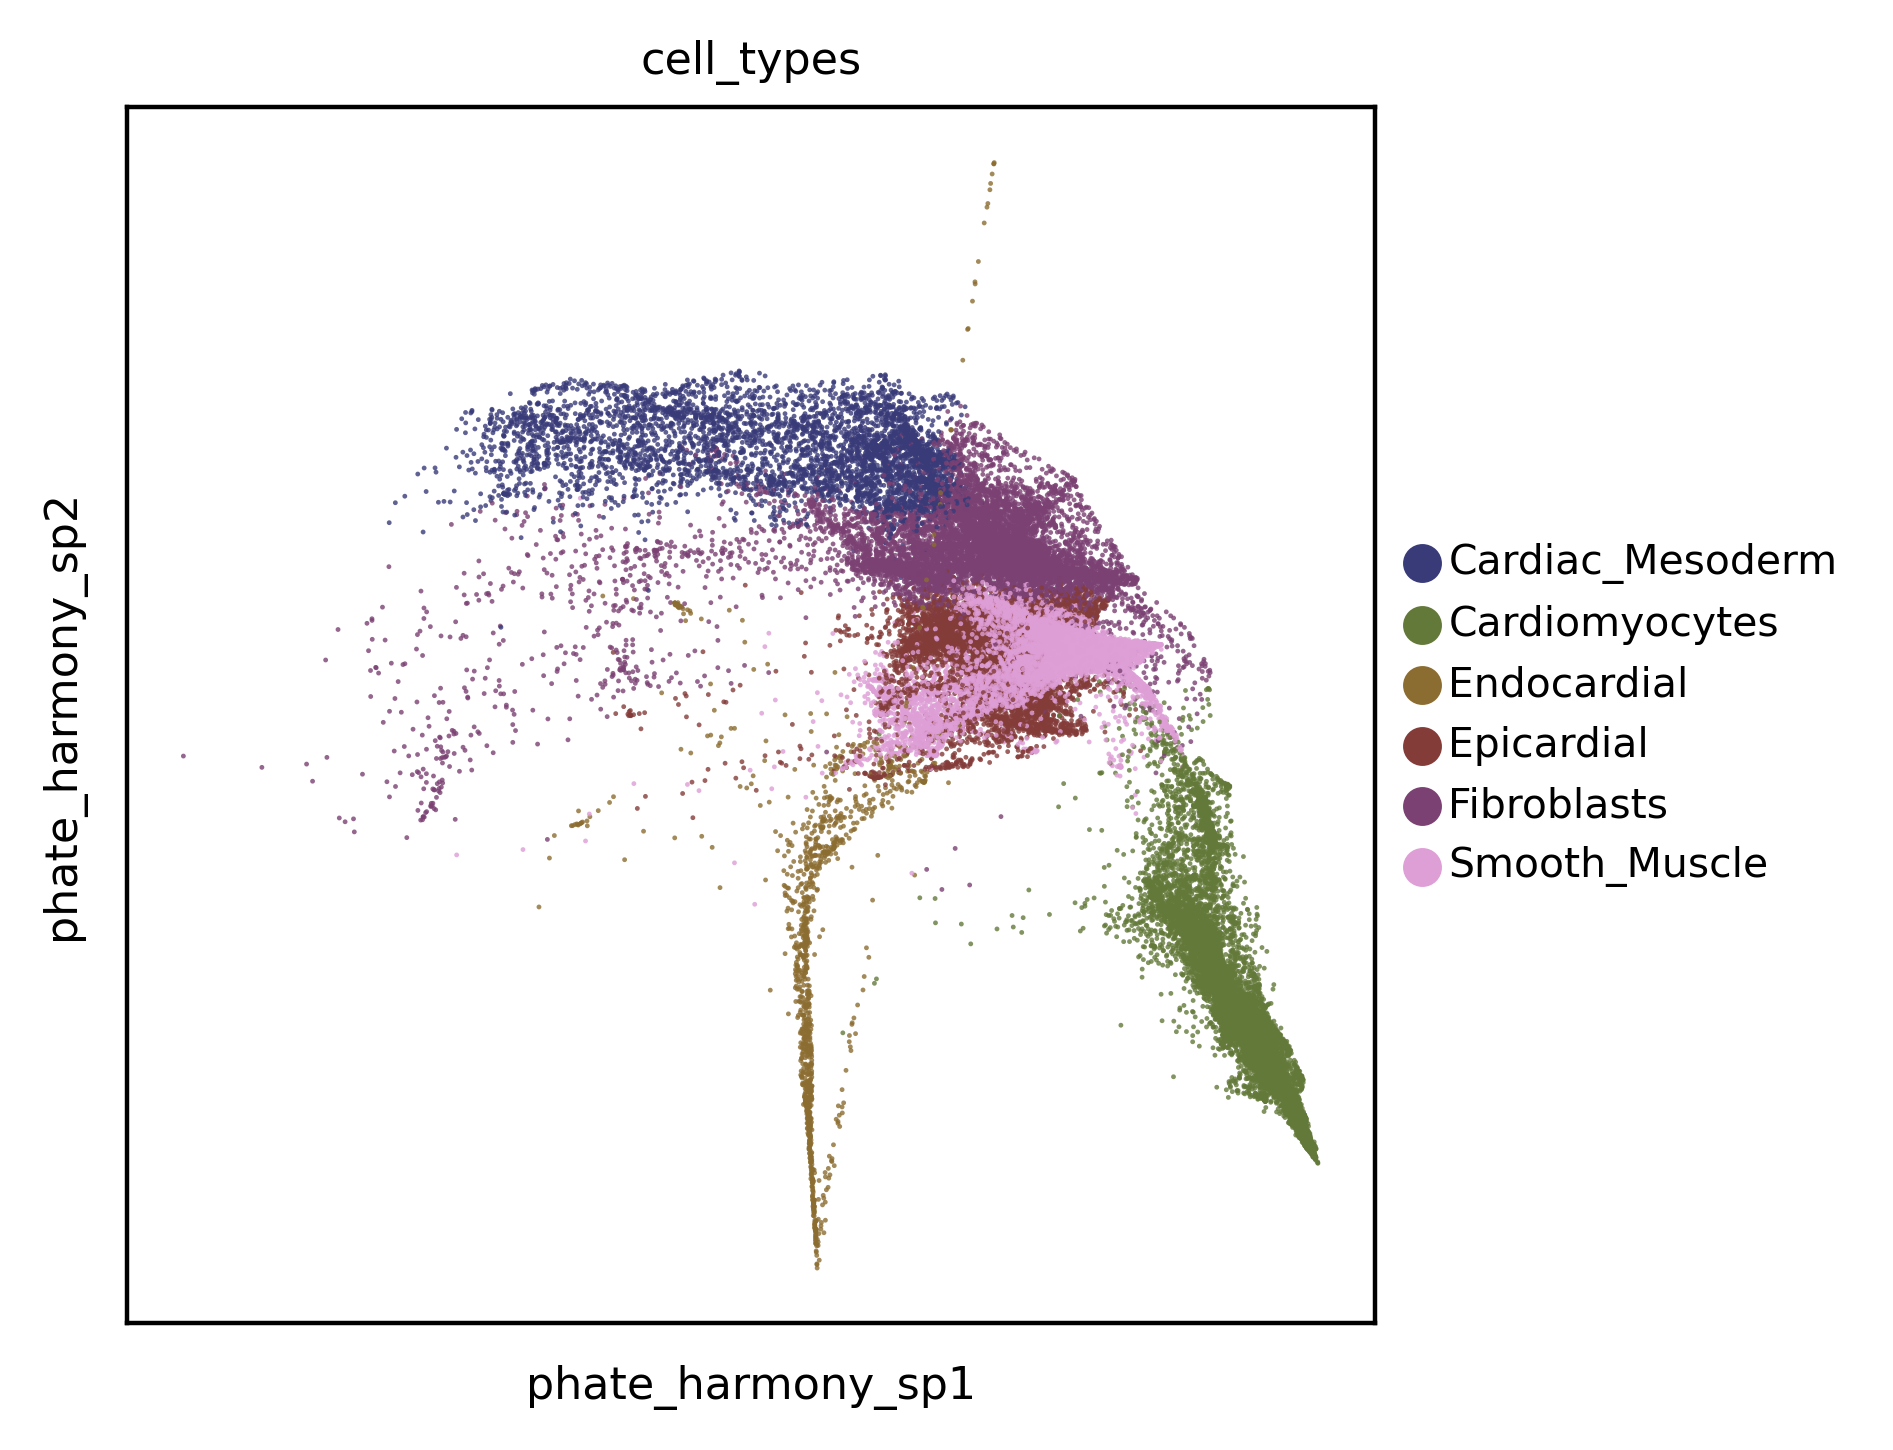

In [22]:
sc.set_figure_params(
    figsize=(4,4),
    fontsize=8,
    transparent=False,
    dpi=200
)
sc.pl.embedding(
    adata,
    basis='phate_harmony_sp',
    # color=['leiden_harmony_sp_10_types','pattern'], 
    color=['cell_types'],
    # edges=True, edges_width=0.01, 
    # legend_loc='on data', legend_fontsize=6,legend_fontoutline=1, #labels on plot
    palette='tab20b',
    color_map='cividis',
    size=3, alpha=0.8,
    sort_order=True,
#     return_fig=True,
    ncols=3
)

In [11]:
import phate

In [26]:
phate_operator = phate.PHATE(
    knn=50,
#     decay=40,
    t='auto',
    mds_solver='smacof',
    n_jobs=64
)

# Use top N harmony dims which account for 95% of variance in harmony embedding
n_dims=npcs(adata,reduction="harmony_sp")
tmp_phate = phate_operator.fit_transform(adata.obsm["harmony_sp"][:,:n_dims]) 
adata.obsm['phate_harmony_sp'] = tmp_phate

Calculating PHATE...
  Running PHATE on 40704 observations and 43 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 86.96 seconds.
    Calculating affinities...
    Calculated affinities in 1.47 seconds.
  Calculated graph and diffusion operator in 89.13 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 14.69 seconds.
    Calculating KMeans...
    Calculated KMeans in 32.05 seconds.
  Calculated landmark operator in 49.54 seconds.
  Calculating optimal t...
    Automatically selected t = 24
  Calculated optimal t in 4.41 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 2.46 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 103.88 seconds.
Calculated PHATE in 249.44 seconds.


/home/dwm269/miniconda3/envs/pyRNA6/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


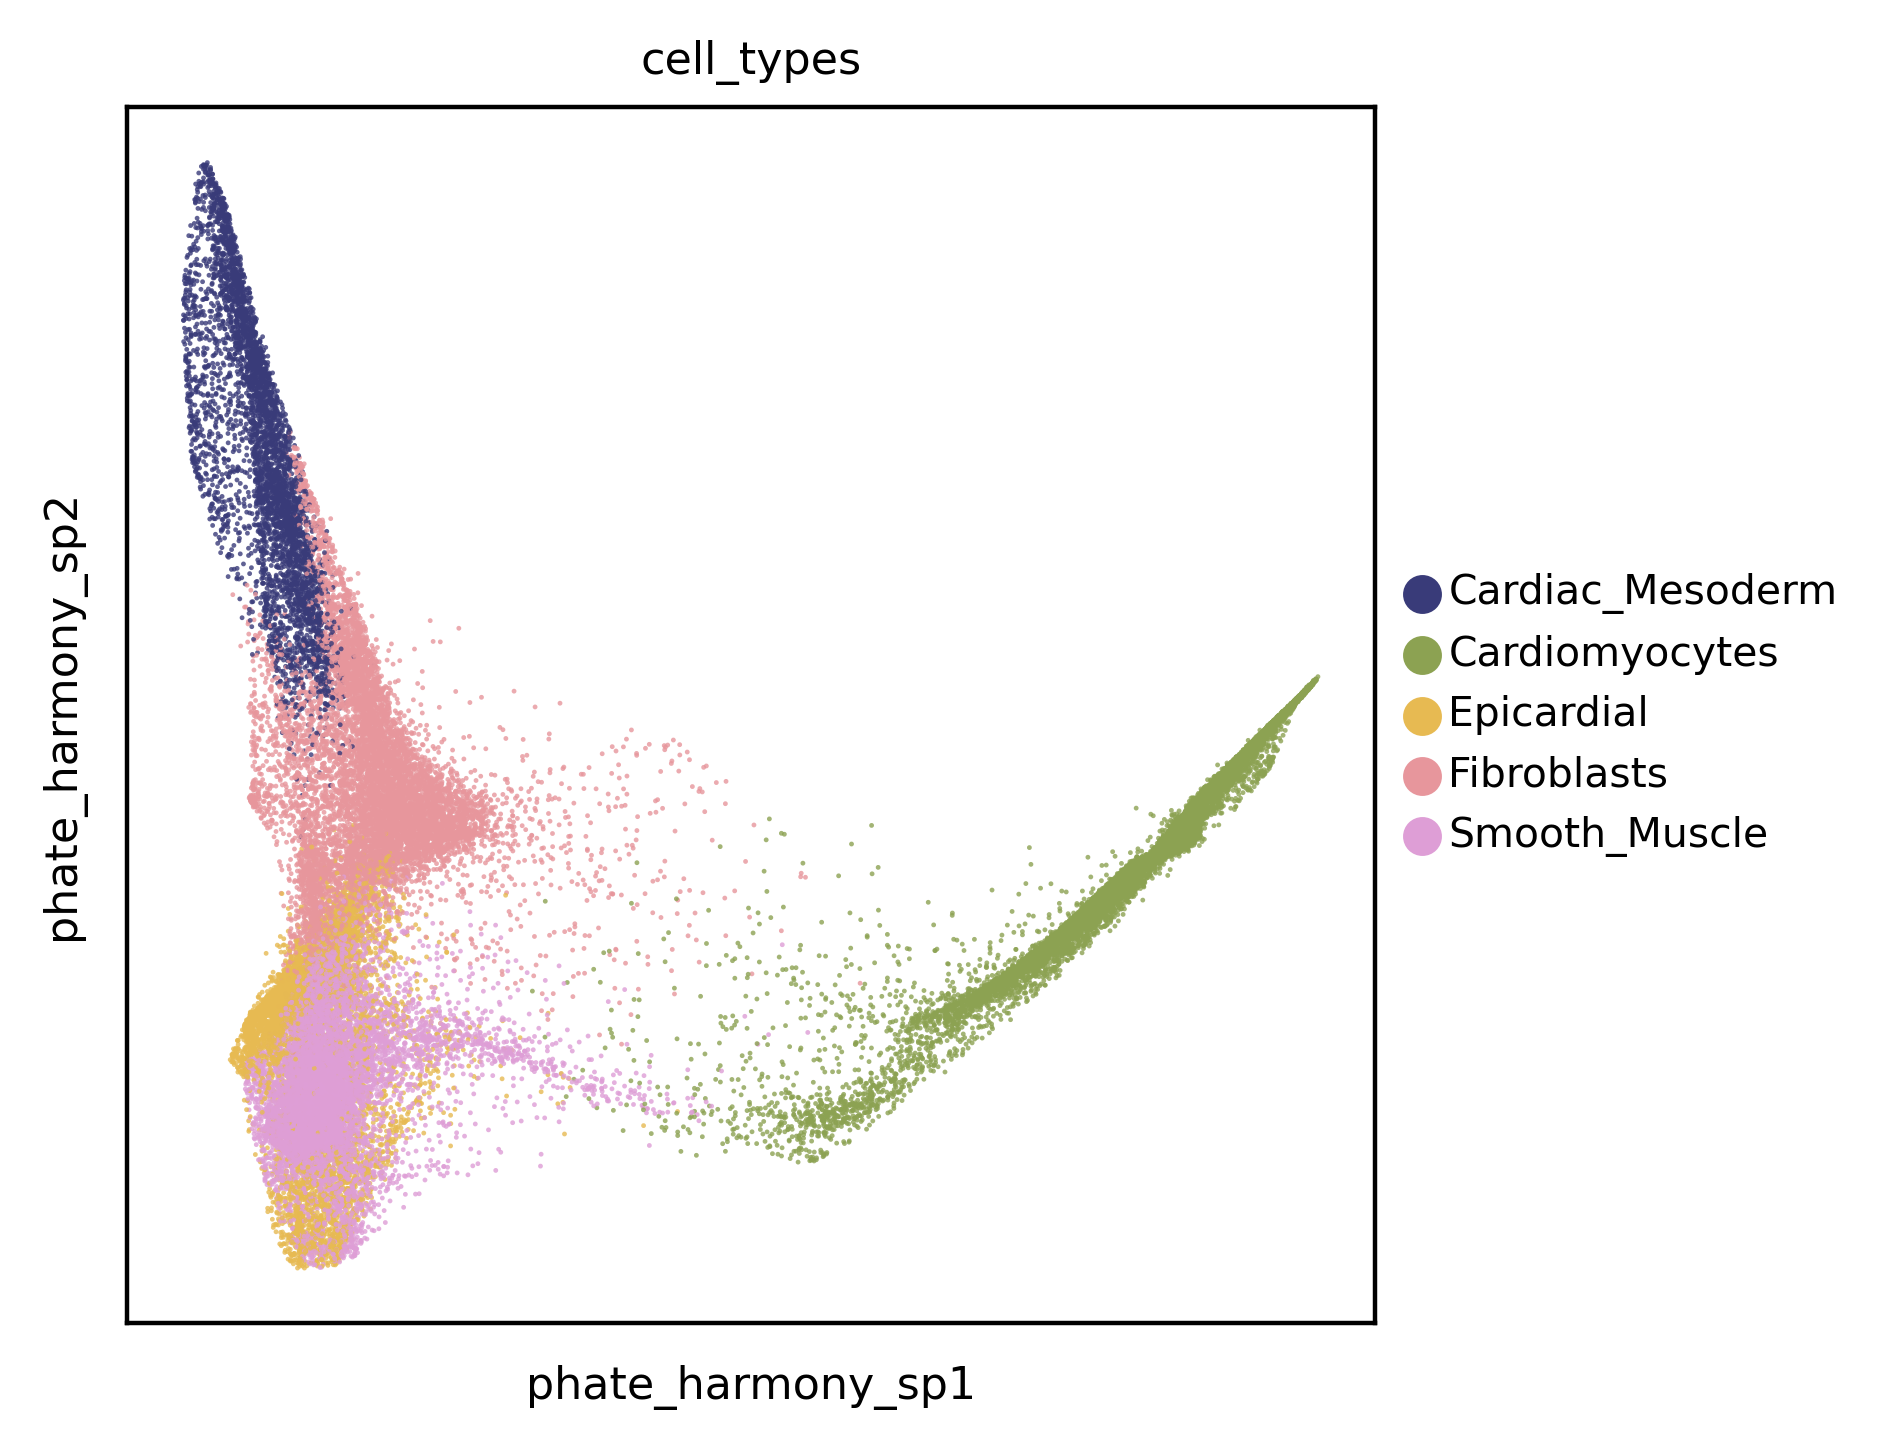

In [27]:
sc.set_figure_params(
    figsize=(4,4),
    fontsize=8,
    transparent=False,
    dpi=200
)
sc.pl.embedding(
    adata,
    basis='phate_harmony_sp',
    # color=['leiden_harmony_sp_10_types','pattern'], 
    color=['cell_types'],
    # edges=True, edges_width=0.01, 
    # legend_loc='on data', legend_fontsize=6,legend_fontoutline=1, #labels on plot
    palette='tab20b',
    color_map='cividis',
    size=3, alpha=0.8,
    sort_order=True,
#     return_fig=True,
    ncols=3
)

### DGEA

In [14]:
sc.tl.rank_genes_groups(
    adata, 
    groupby='leiden_harmony_sp_10_types', 
    method='wilcoxon',
    layer='data',
    pts=True
)

In [15]:
tmp = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
print(tmp.iloc()[1:20,:])

   Cardiomyocytes cardiac_4 Fibroblasts_5 Epicardial Cardiac_Mesoderm_9  \
1          SLC8A1    HAPLN1        COL1A1        EZR              GRID2   
2          PDLIM5     BMPER        TMSB4X      SPARC          MIR302CHG   
3            RYR2      HAS2           FN1    ZNRF2P2              NRXN3   
4             PLN   STEAP1B        TMSB10      PHGDH               ROR1   
5          CTNNA3   DYNC1I1        COL6A2     TMEM98           SERPINE2   
6            MYL4     TENM4        COL1A2   SLC9A3R1               NRG3   
7           MYOM1    PTPN13        PDZRN4       SOX6              CHST9   
8           ACTC1     CGNL1        IGFBP7   LEPROTL1         AC107218.3   
9           TNNI1      P3H2          VCAN     COBLL1          LINC01090   
10         MYBPC3     DSCAM          DLK1      PODXL               ROR2   
11           MYL7   COLEC12       COLEC11      KRT18              ADCY2   
12          TNNC1  HS3ST3A1        COL6A3       KRT8              EOMES   
13         SORBS2       T

In [16]:
sc.tl.rank_genes_groups(
    adata, 'leiden_harmony_sp_10_types', 
    groups=['cardiac_4'], reference='cardiac_12', 
    method='wilcoxon'
)

/home/dwm269/miniconda3/envs/pyRNA6/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


/home/dwm269/miniconda3/envs/pyRNA6/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


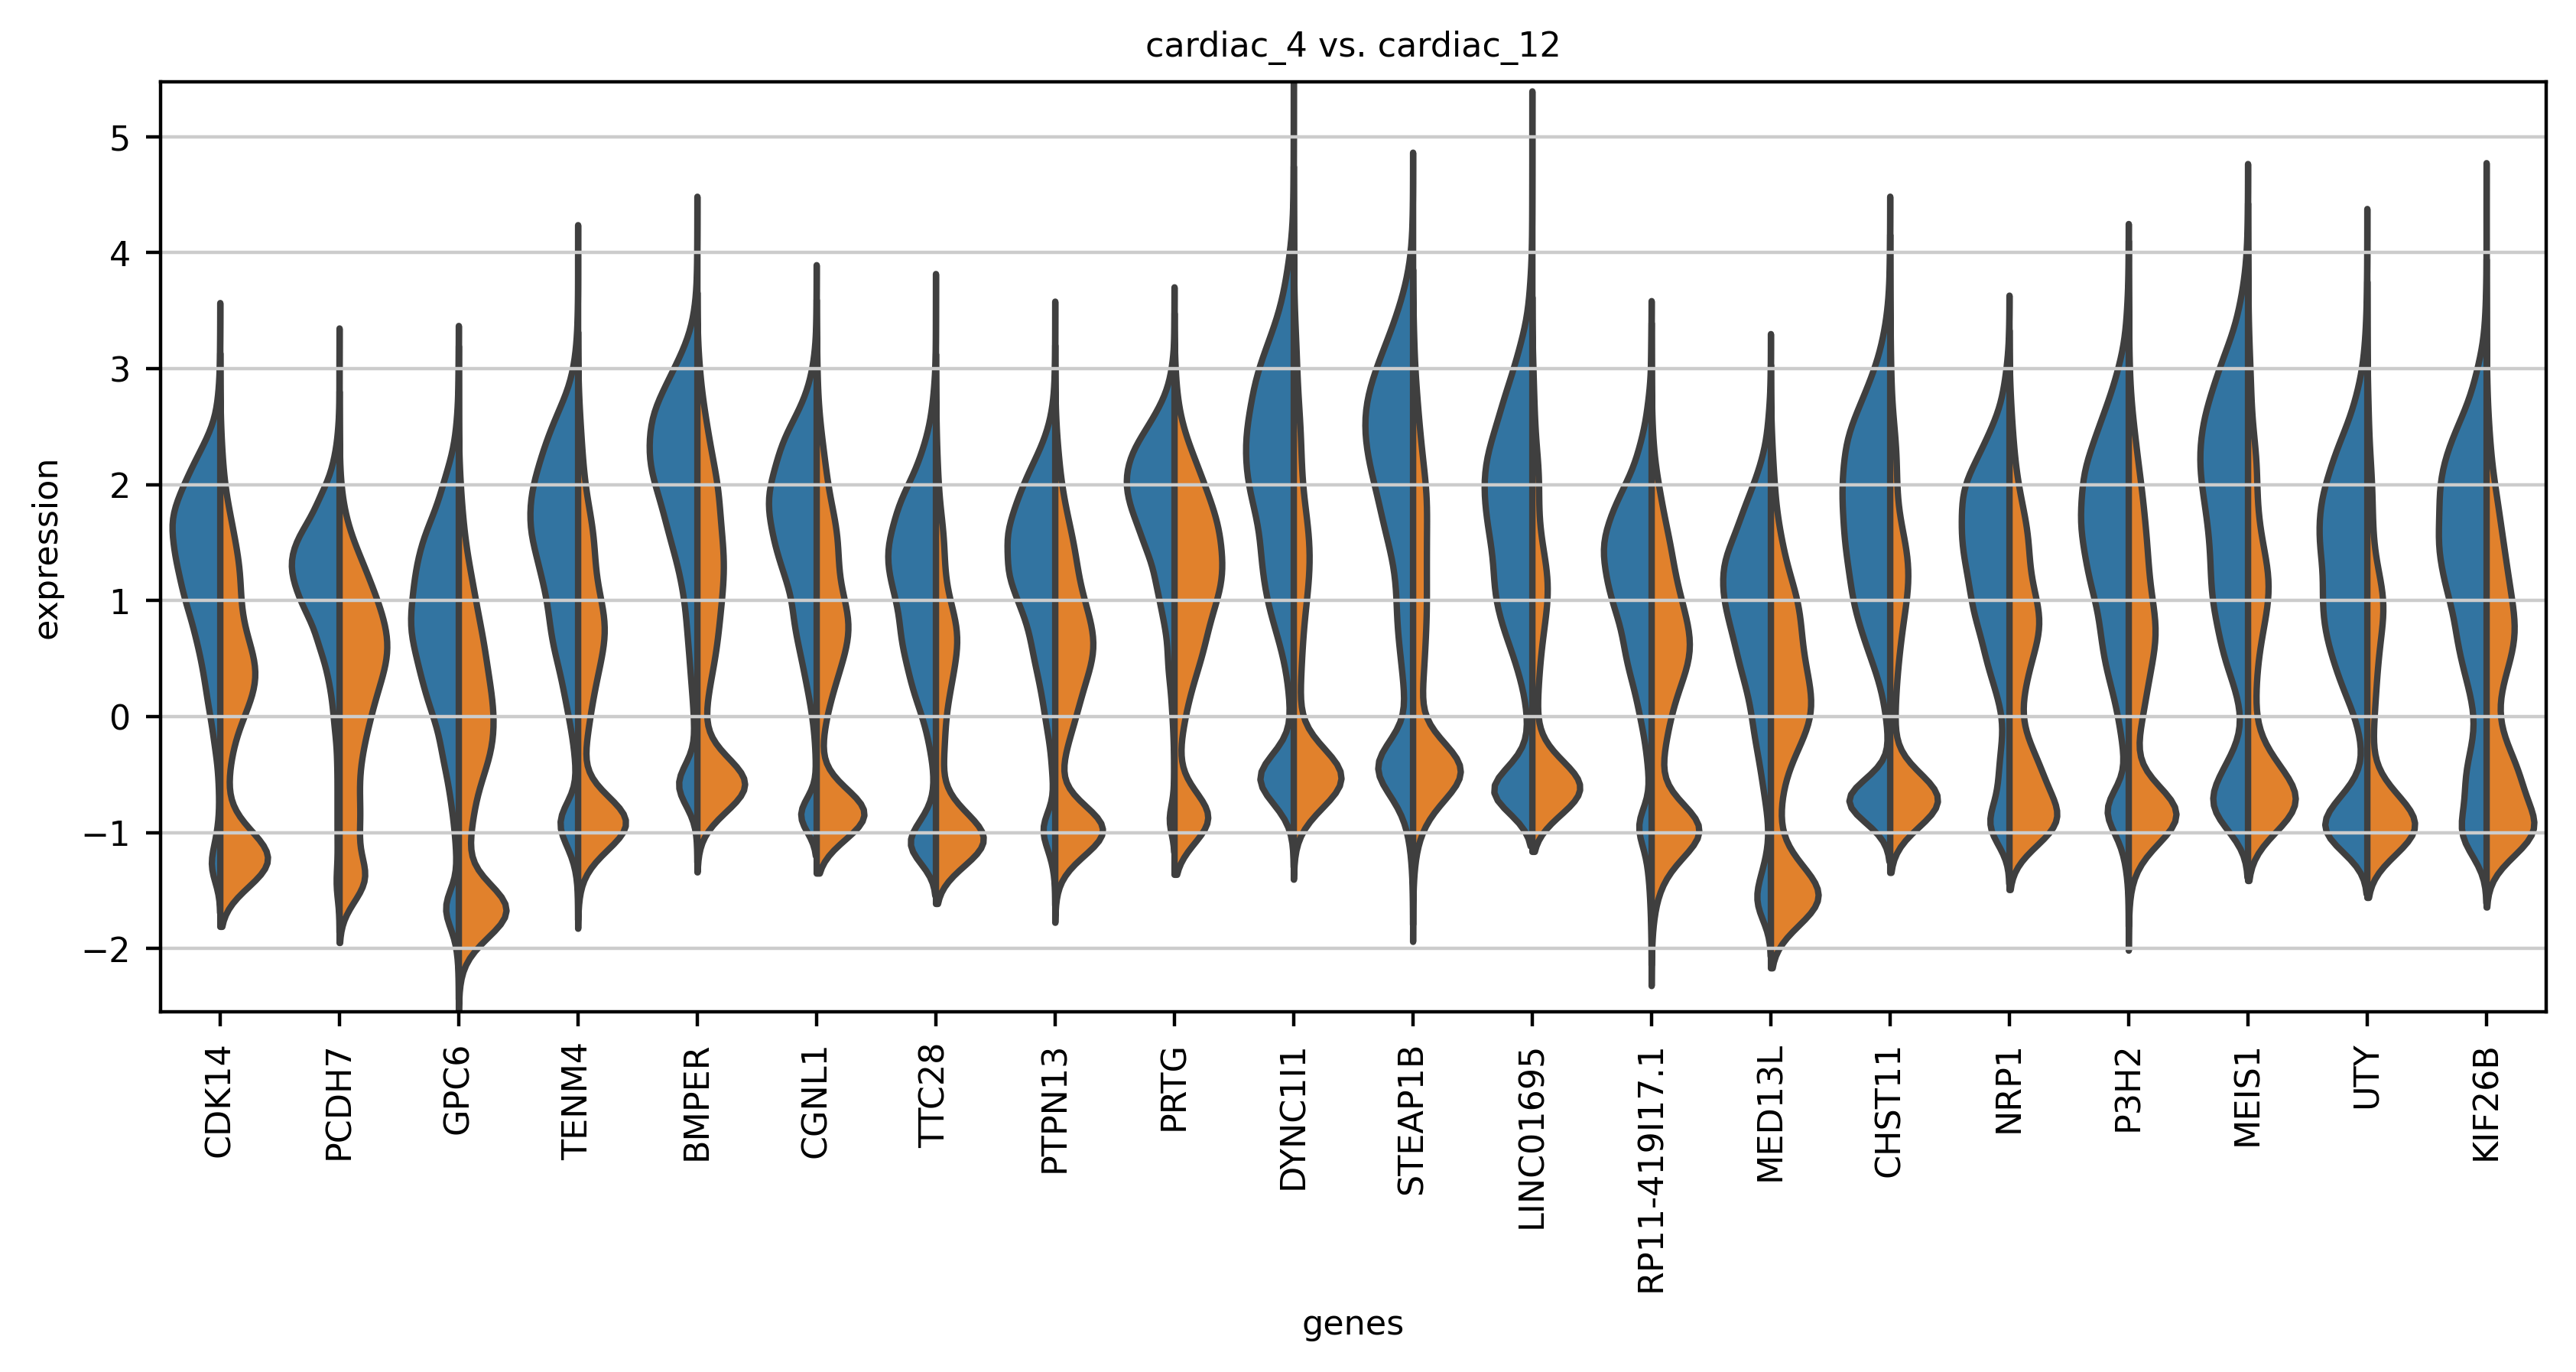

In [17]:
sc.set_figure_params(
    figsize=(10,4),
    fontsize=8,
    transparent=False,
    dpi=200
)
sc.pl.rank_genes_groups_violin(
    adata, 
    groups='cardiac_4', 
    size=0,
    n_genes=20
)